In [ ]:
# ─── Setup ─────────────────────────────────────────────────────────────────────
!pip install diffusers transformers accelerate --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00


In [ ]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import BertTokenizer, BertModel
from PIL import Image
import numpy as np
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.set_default_dtype(torch.float32)
vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="vae"
).to(device,dtype=torch.float32)
vae.eval()


unet = UNet2DConditionModel.from_pretrained("apprisco/ufd_pretrain_e11").to(device,dtype=torch.float32)
unet.eval()

scheduler = DDPMScheduler.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="scheduler"
)

tokenizer    = BertTokenizer.from_pretrained("bert-base-uncased")
text_encoder = BertModel.from_pretrained("bert-base-uncased").to("cpu",dtype=torch.float32)
text_encoder.eval()


Using device: cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
@torch.no_grad()
def generate_images(
    prompts: list[str],
    steps: int = 50,
    guidance_scale: float = 7.5,
    resolution: int = 512,
) -> list[Image.Image]:
    batch = len(prompts)
    toks = tokenizer(
        prompts,
        truncation=True,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        return_tensors="pt"
    )
    cond_embeds = text_encoder(**toks).last_hidden_state
    uncond_toks = tokenizer(
        [""]*batch,
        truncation=True,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        return_tensors="pt"
    )
    uncond_embeds = text_encoder(**uncond_toks).last_hidden_state
    del toks, uncond_toks
    torch.cuda.empty_cache()
    cond_embeds   = cond_embeds.to(device)
    uncond_embeds = uncond_embeds.to(device)
    encoder_states = torch.cat([uncond_embeds, cond_embeds], dim=0)
    latents = torch.randn(
        (batch, unet.config.in_channels, 32, 32),
        device=device
    ) * scheduler.init_noise_sigma
    scheduler.set_timesteps(steps)
    for t in scheduler.timesteps[:steps]:
        lat_in = torch.cat([latents, latents], dim=0)
        noise_pred = unet(lat_in, t, encoder_hidden_states=encoder_states).sample
        uncond_pred, cond_pred = noise_pred.chunk(2)
        guided = uncond_pred + guidance_scale * (cond_pred - uncond_pred)
        latents = scheduler.step(guided, t, latents).prev_sample
    latents = latents / vae.config.scaling_factor
    with torch.no_grad():
        images = vae.decode(latents).sample
    images = (images / 2 + 0.5).clamp(0, 1)
    out = []
    for i in range(batch):
        arr = (images[i].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        out.append(Image.fromarray(arr))
    return out

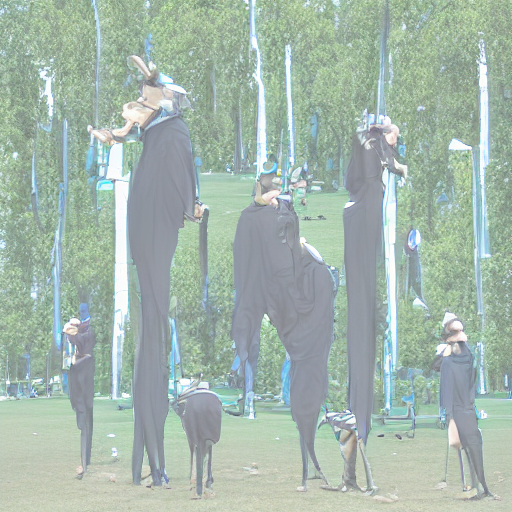

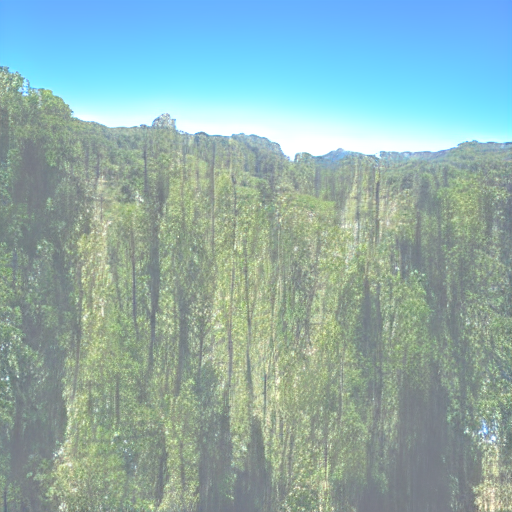

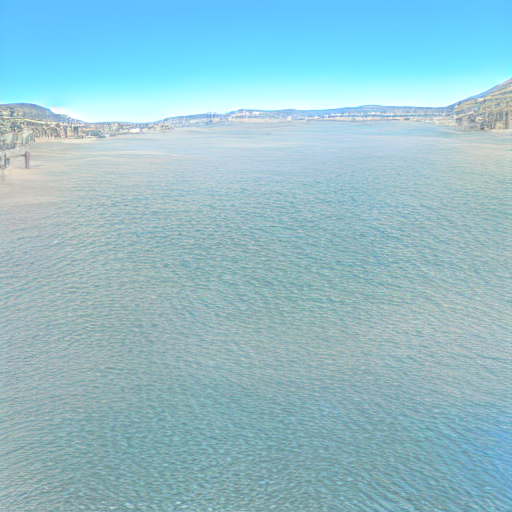

In [ ]:
prompts = ["An astronaut on a horse","A forest from above during the night", "A large, sprawling city"]
images = generate_images(prompts, steps=50, guidance_scale=7.5,resolution=256)
for img in images:
    display(img)